In [3]:
import os, glob, sys
from pathlib import Path
import pandas as pd
import numpy as np
import fitsio
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

In [4]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be:
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm.

     Returns the smoothed velocity components
    """

    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm]) / fwhm**2
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
    else:
        sys.exit('invalid kernel')

    return vxs2, vys2


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    if fov is None:
        vx1f, vx2f, vy1f, vy2f = vx1, vx2, vy1, vy2
    else:
        vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson

ker = 'gaussian'

In [5]:
columns = ['index', 'kernel', 'rs', 'intsteps', 'ballspacing', 'am', 'dp', 'sigma_factor', 'fourier_radius', 'corr', 'corr_top', 'corr_bot', 'RMSE_cal_vx_top', 'MAE_cal_vx_top', 'MAE_cal_vx_bot', 'MAE_cal_vx', 'MAPE', 'MAE_discrep', 'MAPD', 'p_top_0', 'p_bot_0']
caldf = pd.read_csv(Path(os.environ['DATA'],'sanity_check/stein_series/calibration3/correlation_dataframe_boxcar_gaussian.csv'), usecols=columns)
caldf = caldf[caldf['kernel'] == 'gaussian']
caldf = caldf.set_index('index').reset_index()
caldf.drop(['kernel', 'rs'], axis=1, inplace=True)
caldf.head()

,index,intsteps,ballspacing,am,dp,sigma_factor,fourier_radius,corr,corr_top,corr_bot,MAE_cal_vx,MAE_cal_vx_top,MAE_cal_vx_bot,RMSE_cal_vx_top,MAE_discrep,MAPE,MAPD,p_top_0,p_bot_0
0,0,3,1,0.3,0.1,1.0,0,0.922980,0.912834,0.896699,145.405131,154.790349,168.972783,195.868626,96.658772,20.839322,15.471865,5.901525,6.684215
1,1,3,1,0.3,0.1,1.0,1,0.965759,0.960055,0.954099,100.316700,108.974928,114.074341,138.843269,67.309539,15.372926,11.271482,6.495159,8.560860
2,2,3,1,0.3,0.1,1.0,2,0.965670,0.959237,0.954984,101.410126,108.830651,112.436553,138.422508,66.558813,15.871259,10.689293,6.269682,8.158298
3,3,3,1,0.3,0.1,1.0,3,0.964313,0.958023,0.953026,102.538378,111.200682,118.320086,139.852557,67.686284,15.980173,11.002996,5.947756,7.597795
4,4,3,1,0.3,0.1,1.0,4,0.964446,0.958044,0.953389,100.830462,108.998298,115.488298,138.746032,67.989535,15.995259,11.037428,5.612743,6.973218


In [6]:
caldf = caldf.query('ballspacing == 1')
caldf.head()

,index,intsteps,ballspacing,am,dp,sigma_factor,fourier_radius,corr,corr_top,corr_bot,MAE_cal_vx,MAE_cal_vx_top,MAE_cal_vx_bot,RMSE_cal_vx_top,MAE_discrep,MAPE,MAPD,p_top_0,p_bot_0
0,0,3,1,0.3,0.1,1.0,0,0.922980,0.912834,0.896699,145.405131,154.790349,168.972783,195.868626,96.658772,20.839322,15.471865,5.901525,6.684215
1,1,3,1,0.3,0.1,1.0,1,0.965759,0.960055,0.954099,100.316700,108.974928,114.074341,138.843269,67.309539,15.372926,11.271482,6.495159,8.560860
2,2,3,1,0.3,0.1,1.0,2,0.965670,0.959237,0.954984,101.410126,108.830651,112.436553,138.422508,66.558813,15.871259,10.689293,6.269682,8.158298
3,3,3,1,0.3,0.1,1.0,3,0.964313,0.958023,0.953026,102.538378,111.200682,118.320086,139.852557,67.686284,15.980173,11.002996,5.947756,7.597795
4,4,3,1,0.3,0.1,1.0,4,0.964446,0.958044,0.953389,100.830462,108.998298,115.488298,138.746032,67.989535,15.995259,11.037428,5.612743,6.973218


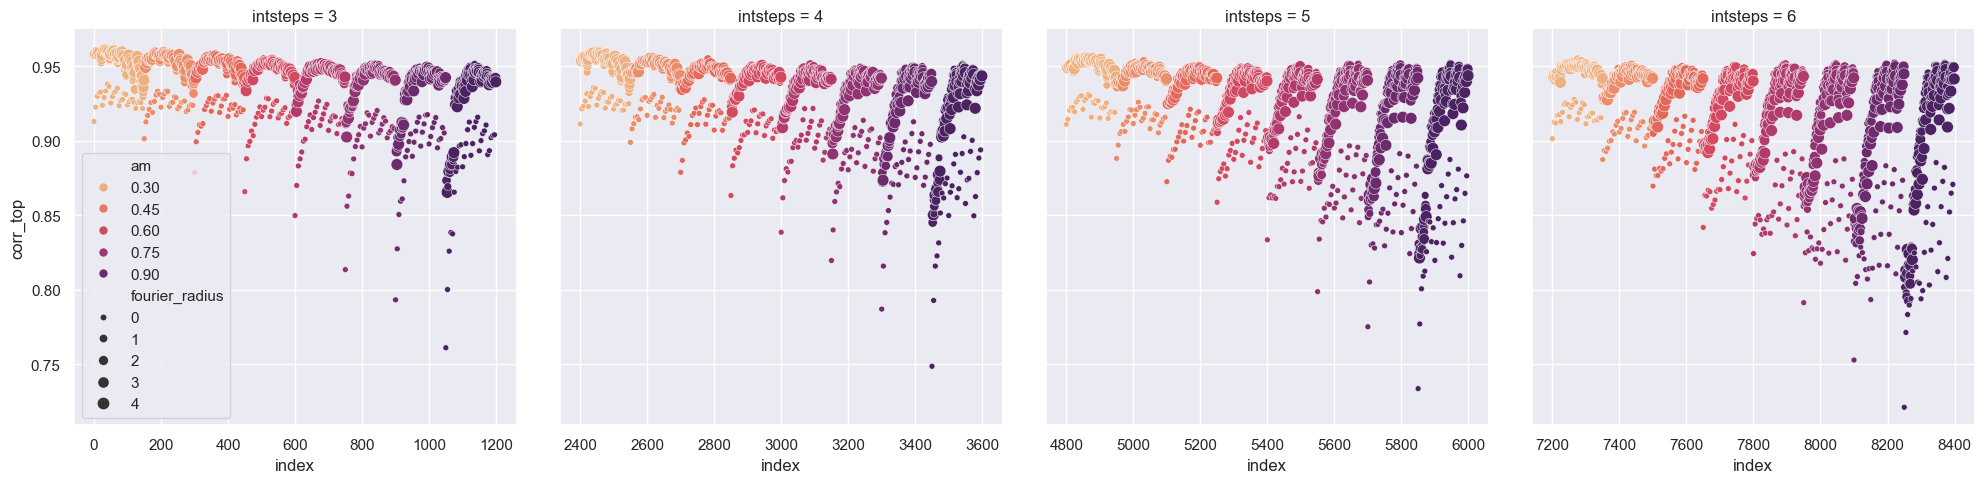

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf,
    x='index',
    y='corr_top',
    col='intsteps',
    size='fourier_radius',
    hue = 'am',
    palette=sns.color_palette("flare", as_cmap=True),
    height=5, aspect=1, 
    facet_kws={'sharex':False, 'legend_out':False}
)
xspan = 2400
xgroups = [xspan, 2*xspan, 3*xspan]
for i, idx in enumerate(xgroups):
    ax = g.facet_axis(0, i)
    # ax.set_ylim([0.8, 0.97])
    
plt.subplots_adjust(wspace=0.1)
plt.show()

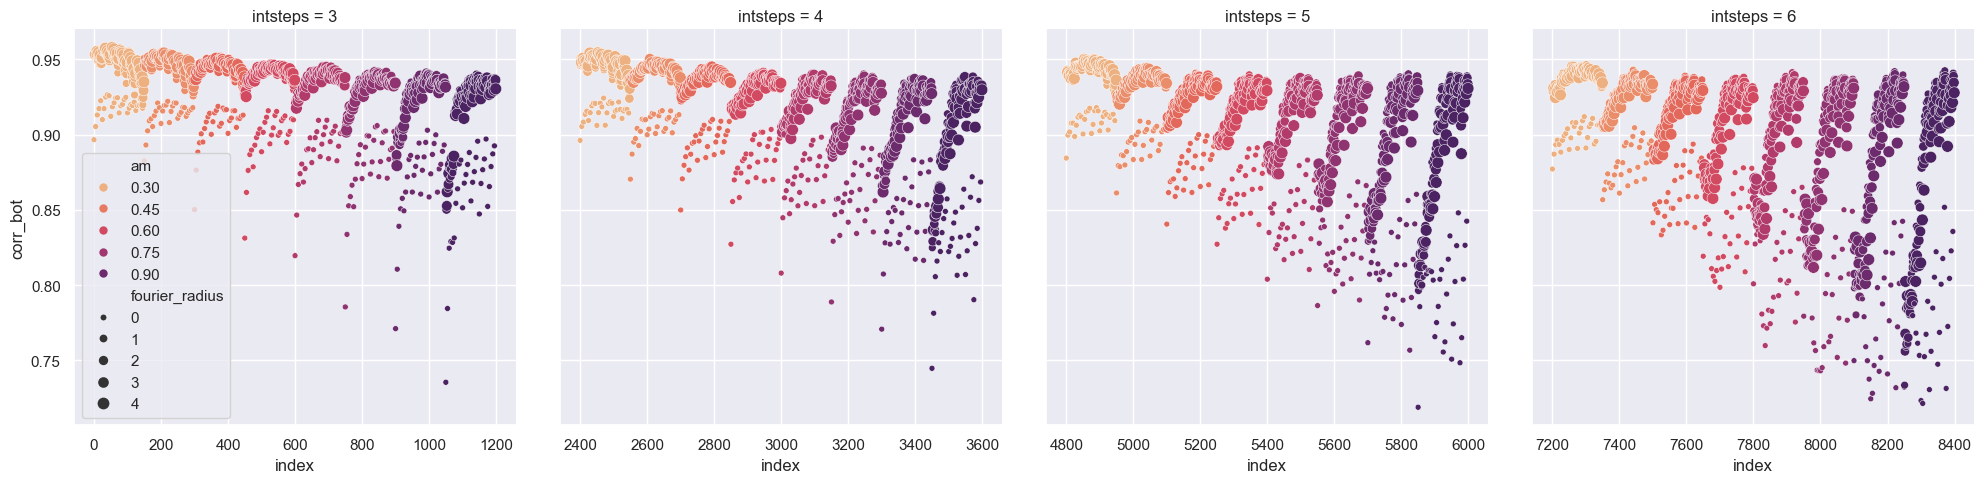

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf,
    x='index',
    y='corr_bot',
    col='intsteps',
    size='fourier_radius',
    hue = 'am',
    palette=sns.color_palette("flare", as_cmap=True),
    height=5, aspect=1, 
    facet_kws={'sharex':False, 'legend_out':False}
)
xspan = 2400
xgroups = [xspan, 2*xspan, 3*xspan]
for i, idx in enumerate(xgroups):
    ax = g.facet_axis(0, i)
    # ax.set_ylim([0.8, 0.97])
    
plt.subplots_adjust(wspace=0.1)
plt.show()

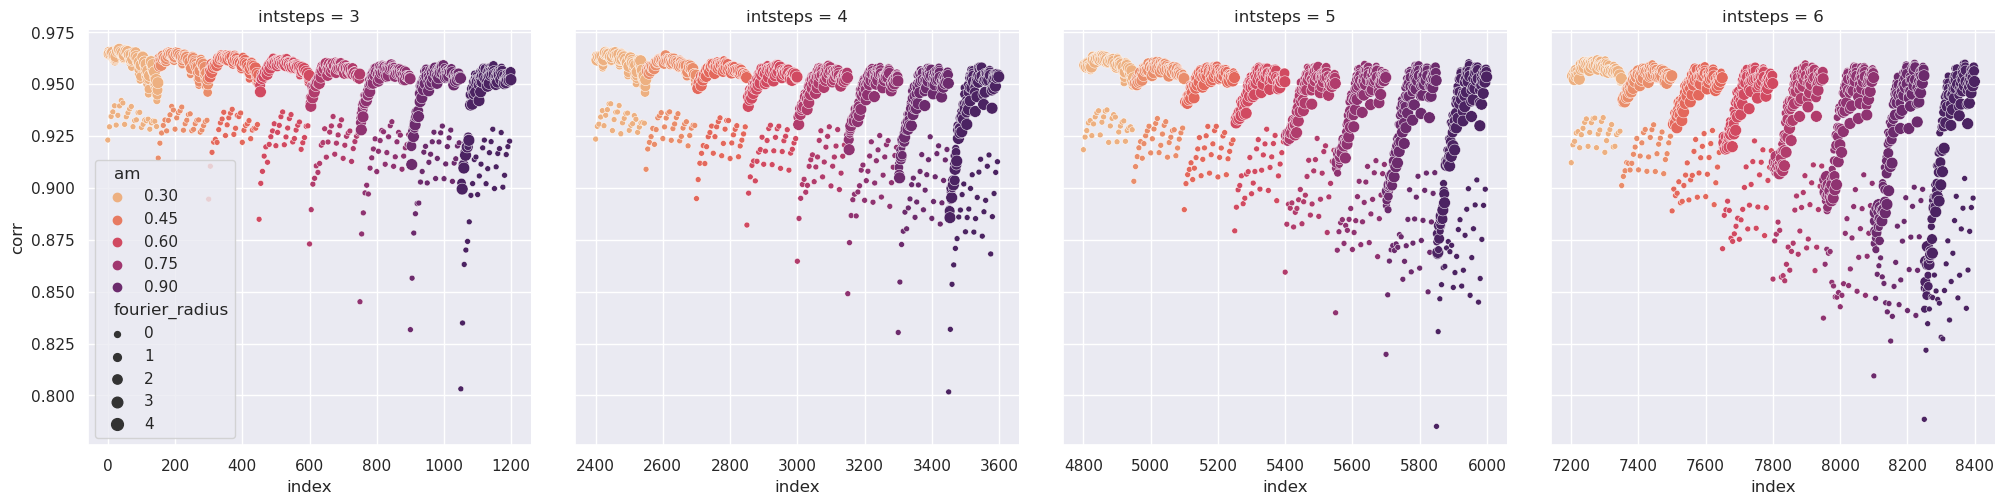

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf,
    x='index',
    y='corr',
    col='intsteps',
    size='fourier_radius',
    hue = 'am',
    palette=sns.color_palette("flare", as_cmap=True),
    height=5, aspect=1, 
    facet_kws={'sharex':False, 'legend_out':False}
)
xspan = 2400
xgroups = [xspan, 2*xspan, 3*xspan]
for i, idx in enumerate(xgroups):
    ax = g.facet_axis(0, i)
    # ax.set_ylim([0.8, 0.97])
    
plt.subplots_adjust(wspace=0.1)
plt.show()

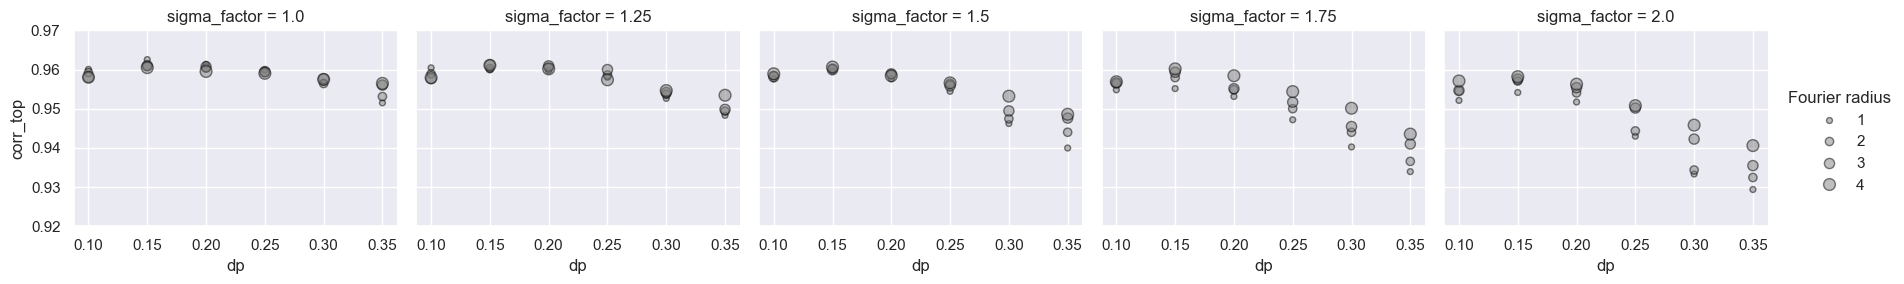

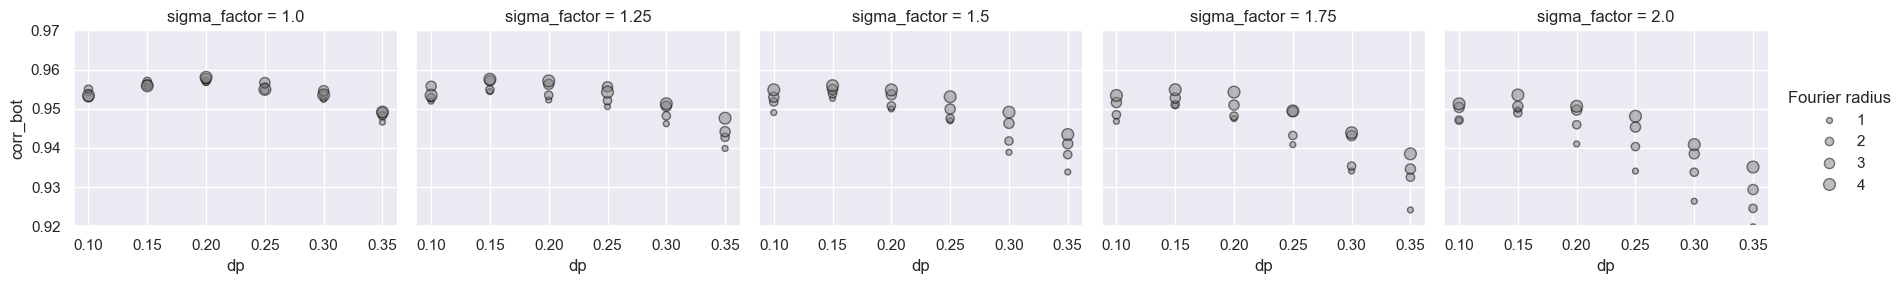

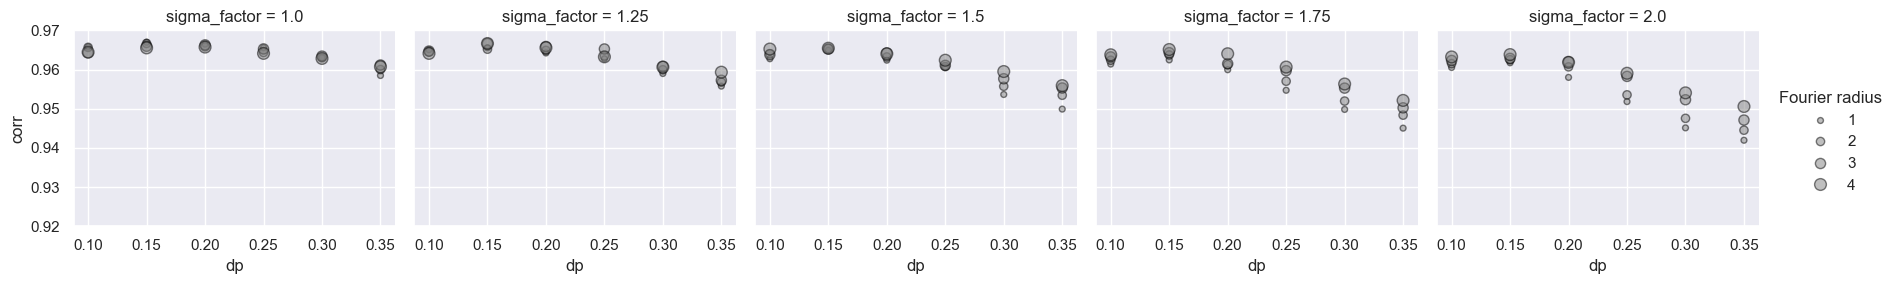

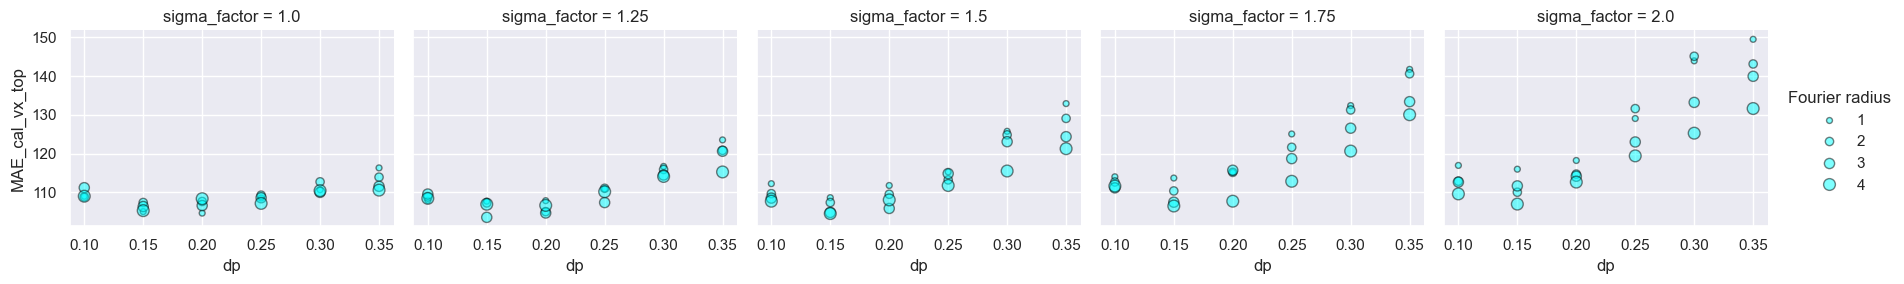

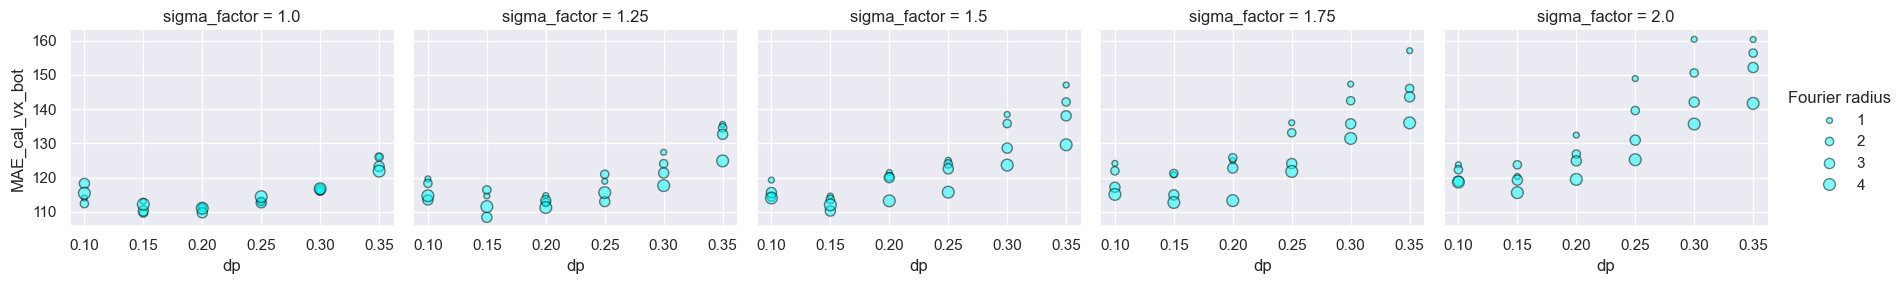

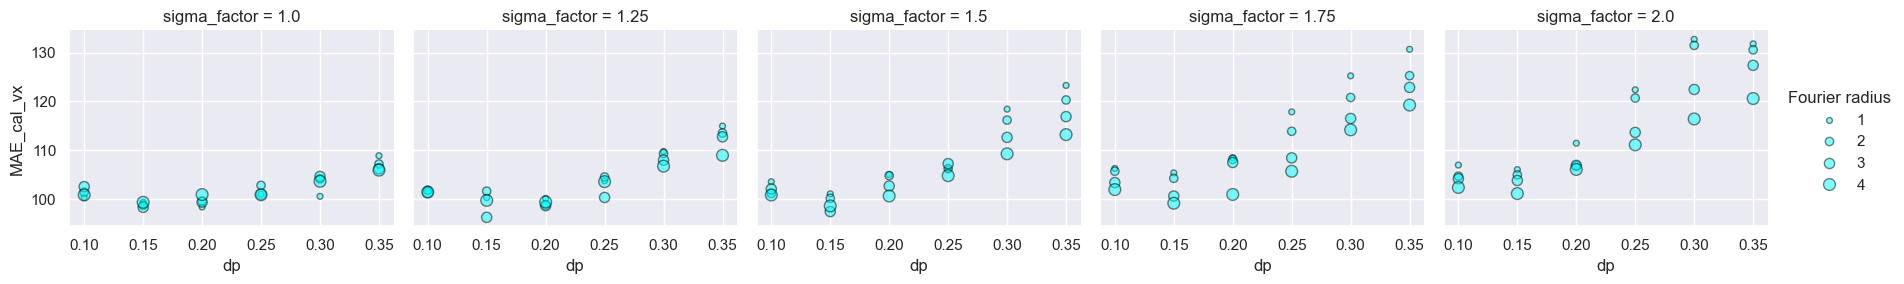

In [156]:
sizes = ((np.arange(1,5)**2)*10).tolist()

plt.close('all')
sns.set_theme()

g1 = sns.FacetGrid(caldf.query('intsteps ==3 & am == 0.3 & fourier_radius > 0'), col='sigma_factor', height=3, aspect=1.2)
g1.map_dataframe(sns.scatterplot, x='dp', y='corr_top', size='fourier_radius', alpha=0.5, color='gray', edgecolor='black', linewidth=1)
g1.add_legend(title='Fourier radius')
g1.set(ylim=(0.92, 0.97))

g2 = sns.FacetGrid(caldf.query('intsteps ==3 & am == 0.3 & fourier_radius > 0'), col='sigma_factor', height=3, aspect=1.2)
g2.map_dataframe(sns.scatterplot, x='dp', y='corr_bot', size='fourier_radius', alpha=0.5, color='gray', edgecolor='black', linewidth=1)
g2.add_legend(title='Fourier radius')
g2.set(ylim=(0.92, 0.97))

g3 = sns.FacetGrid(caldf.query('intsteps ==3 & am == 0.3 & fourier_radius > 0'), col='sigma_factor', height=3, aspect=1.2)
g3.map_dataframe(sns.scatterplot, x='dp', y='corr', size='fourier_radius', alpha=0.5, color='gray', edgecolor='black', linewidth=1)
g3.add_legend(title='Fourier radius')
g3.set(ylim=(0.92, 0.97))


h1 = sns.FacetGrid(caldf.query('intsteps ==3 & am == 0.3 & fourier_radius > 0'), col='sigma_factor', height=3, aspect=1.2)
h1.map_dataframe(sns.scatterplot, x='dp', y='MAE_cal_vx_top', size='fourier_radius', alpha=0.5, color='cyan', edgecolor='black', linewidth=1)
h1.add_legend(title='Fourier radius')

h2 = sns.FacetGrid(caldf.query('intsteps ==3 & am == 0.3 & fourier_radius > 0'), col='sigma_factor', height=3, aspect=1.2)
h2.map_dataframe(sns.scatterplot, x='dp', y='MAE_cal_vx_bot', size='fourier_radius', alpha=0.5, color='cyan', edgecolor='black', linewidth=1)
h2.add_legend(title='Fourier radius')

h3 = sns.FacetGrid(caldf.query('intsteps ==3 & am == 0.3 & fourier_radius > 0'), col='sigma_factor', height=3, aspect=1.2)
h3.map_dataframe(sns.scatterplot, x='dp', y='MAE_cal_vx', size='fourier_radius', alpha=0.5, color='cyan', edgecolor='black', linewidth=1)
h3.add_legend(title='Fourier radius')

plt.show()

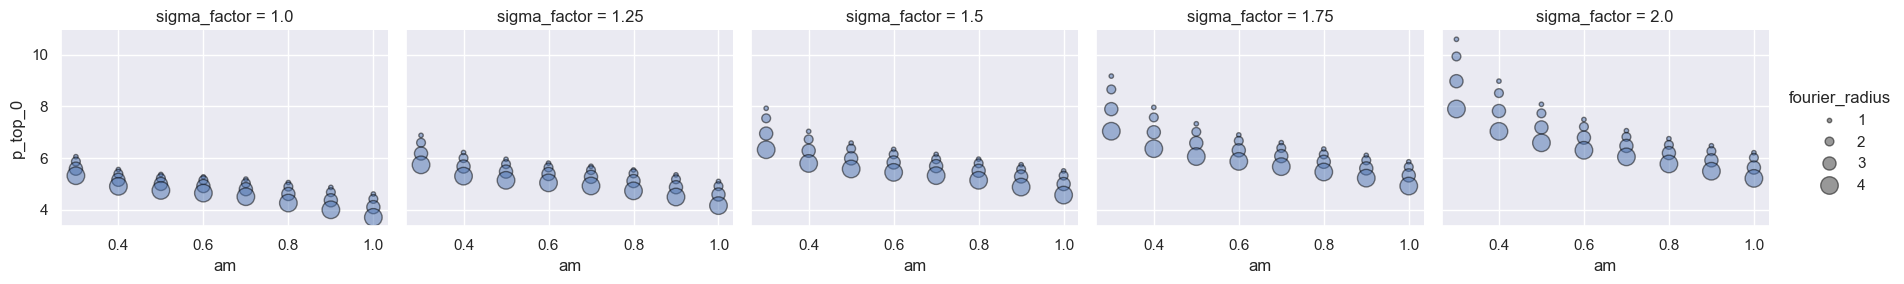

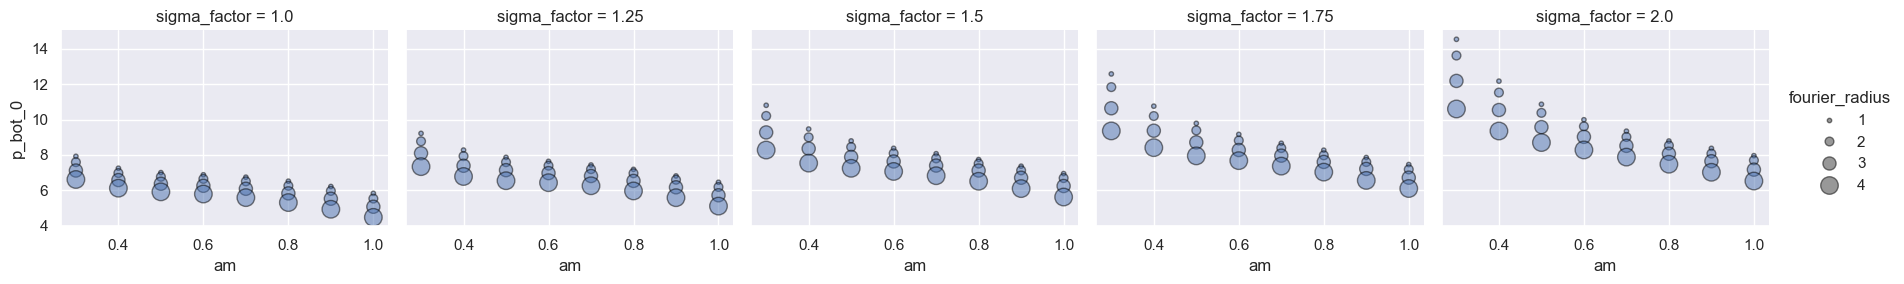

In [157]:
g1 = sns.relplot(
    data=caldf.query('intsteps == 3 & dp == 0.15 & fourier_radius > 0'),
    x='am',
    y='p_top_0',
    col='sigma_factor',
    size='fourier_radius',
    edgecolor='black',
    linewidth=1,
    sizes=sizes,
    alpha=0.5,
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

g2 = sns.relplot(
    data=caldf.query('intsteps == 3 & dp == 0.15 & fourier_radius > 0'),
    x='am',
    y='p_bot_0',
    col='sigma_factor',
    size='fourier_radius',
    edgecolor='black',
    linewidth=1,
    sizes=sizes,
    alpha=0.5,
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.show()

In [170]:
caldf.query('intsteps == 3 & am == 0.3 & dp==0.2 & sigma_factor == 1.0 & fourier_radius == 4')

,index,intsteps,ballspacing,am,dp,sigma_factor,fourier_radius,corr,corr_top,corr_bot,MAE_cal_vx,MAE_cal_vx_top,MAE_cal_vx_bot,RMSE_cal_vx_top,MAE_discrep,MAPE,MAPD,p_top_0,p_bot_0
54,54,3,1,0.3,0.2,1.0,4,0.965742,0.959515,0.958027,100.910503,108.357206,111.104859,136.746866,60.97506,14.60674,9.743118,5.423577,6.666287


## What about the discrepancy between top and bottom? 

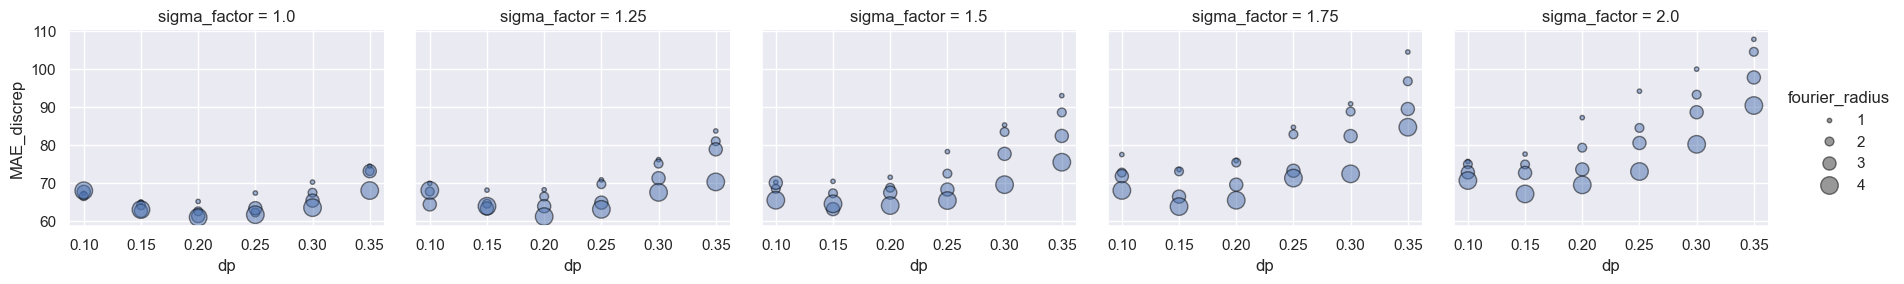

In [160]:
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3 & fourier_radius>0'),
    x='dp',
    y='MAE_discrep',
    col='sigma_factor',
    size='fourier_radius',
    edgecolor='black',
    linewidth=1,
    sizes=sizes,
    alpha=0.5,
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

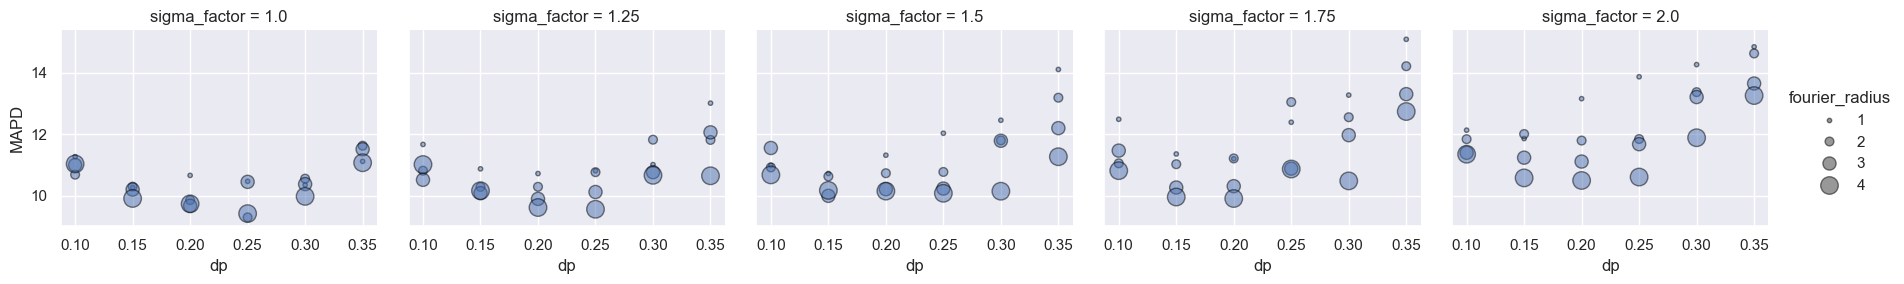

In [163]:
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3 & fourier_radius>0'),
    x='dp',
    y='MAPD',
    col='sigma_factor',
    size='fourier_radius',
    edgecolor='black',
    linewidth=1,
    sizes=sizes,
    alpha=0.5,
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

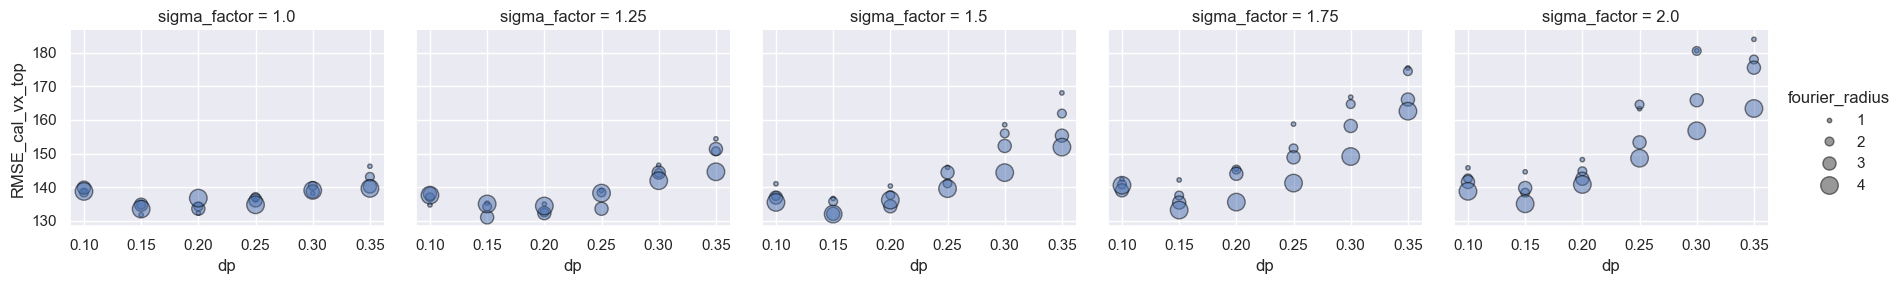

In [164]:
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3 & fourier_radius>0'),
    x='dp',
    y='RMSE_cal_vx_top',
    col='sigma_factor',
    size='fourier_radius',
    edgecolor='black',
    linewidth=1,
    sizes=sizes,
    alpha=0.5,
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

In [165]:
caldf.query('fourier_radius > 0 & intsteps == 4 & ballspacing == 1 & fourier_radius == 1 & sigma_factor == 2')[['am', 'dp', 'corr_top']].head()

,am,dp,corr_top
2421,0.3,0.10,0.945849
2446,0.3,0.15,0.953832
2471,0.3,0.20,0.950471
2496,0.3,0.25,0.944932
2521,0.3,0.30,0.939479


dp       0.10      0.15      0.20      0.25      0.30      0.35
am                                                             
0.3  0.945849  0.953832  0.950471  0.944932  0.939479  0.932130
0.4  0.946150  0.952682  0.949495  0.947213  0.940824  0.937417
0.5  0.941867  0.948787  0.949607  0.946582  0.941664  0.942657
0.6  0.935254  0.943830  0.948148  0.949391  0.945232  0.939076
0.7  0.921140  0.938998  0.946931  0.944985  0.946000  0.942367


<Axes: xlabel='dp', ylabel='am'>

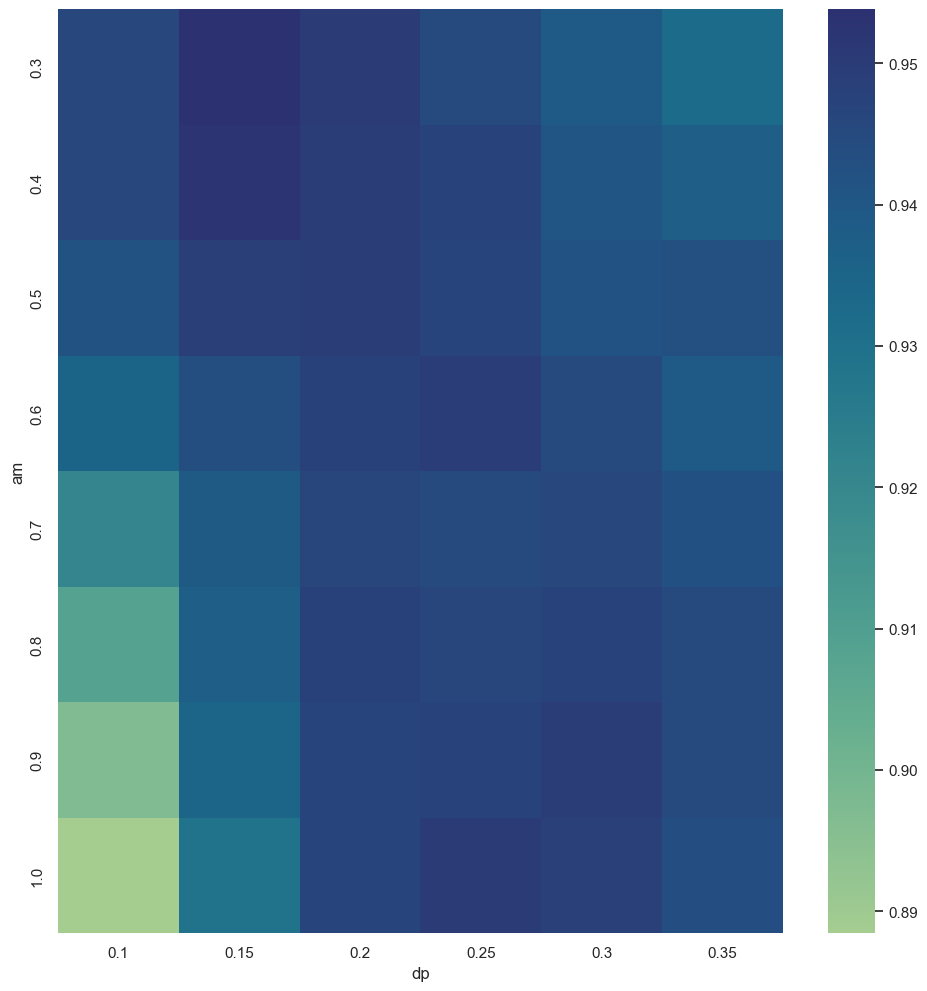

In [166]:
pt = caldf.query('fourier_radius > 0 & intsteps == 4 & ballspacing == 1 & fourier_radius == 1 & sigma_factor == 2')[['am', 'dp', 'corr_top']].pivot(index='am', columns='dp', values= 'corr_top')
print(pt.head())
sns.heatmap(pt, cmap='crest')

In [167]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    heatmap_data = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(heatmap_data, **kwargs)
    ax.invert_yaxis()

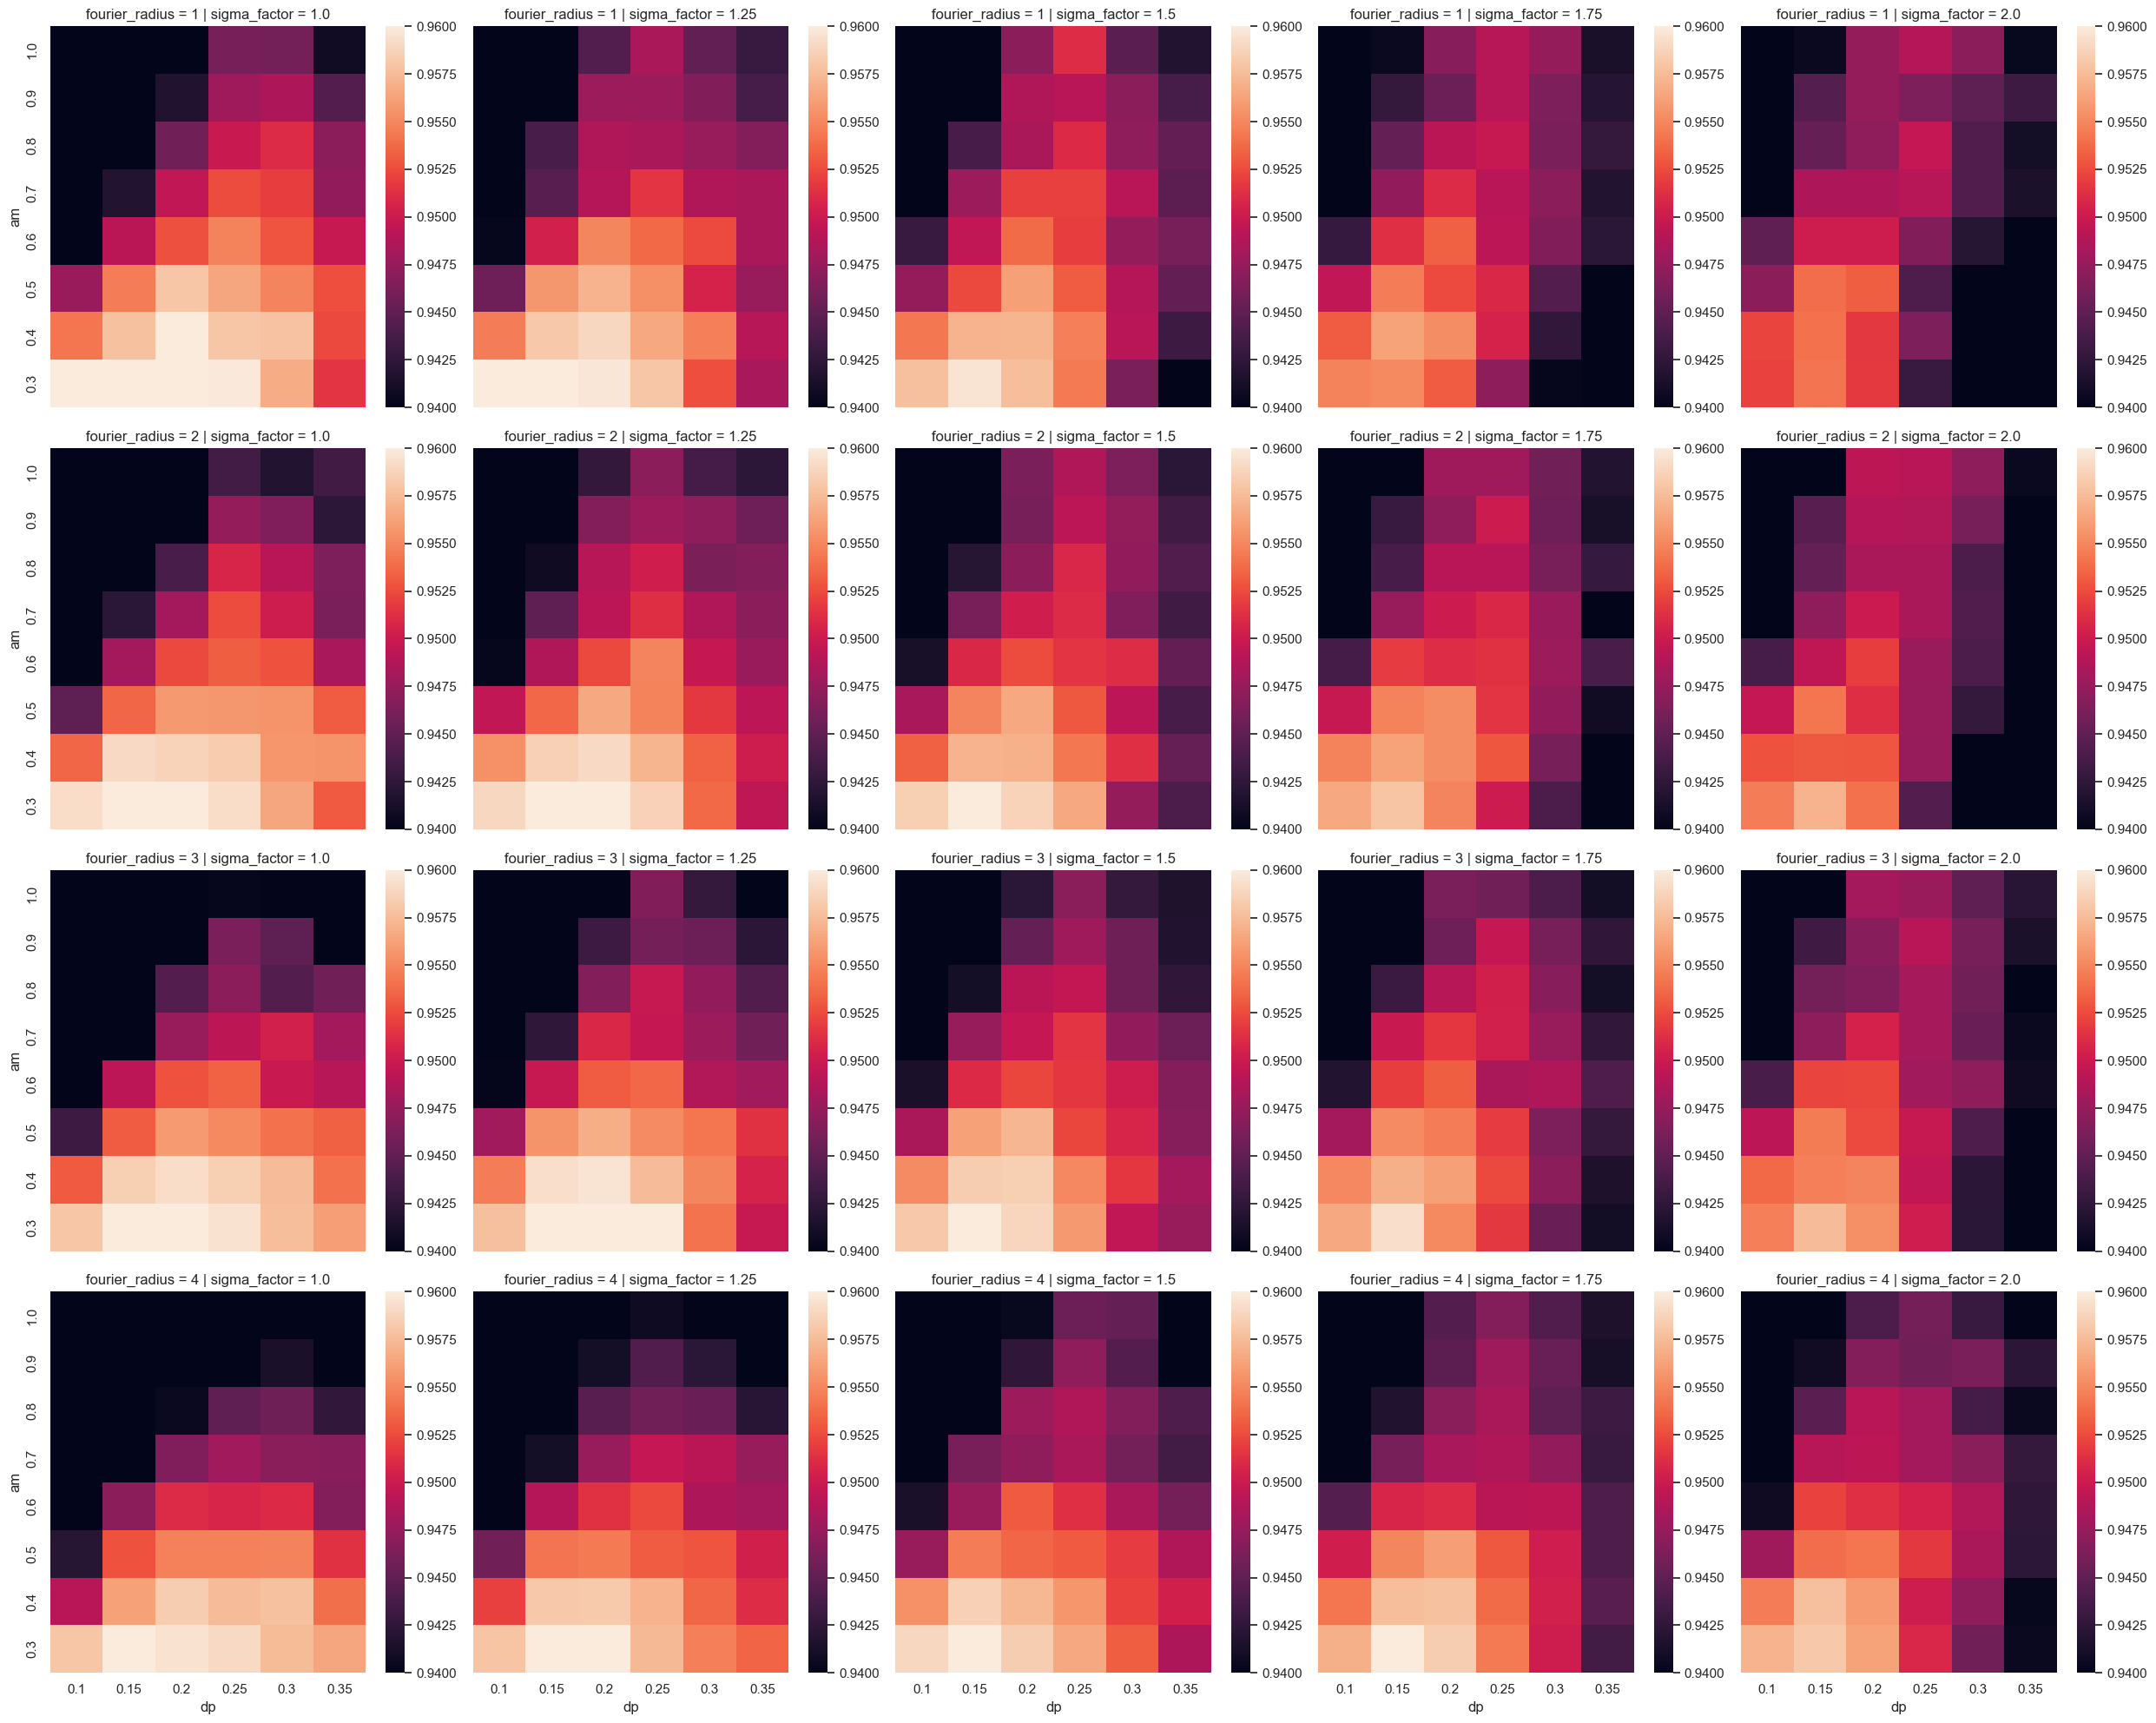

In [174]:
sns.set(font_scale=1) 

vmin=0.94
vmax=0.96
data = caldf.query('fourier_radius > 0 & intsteps == 3 & ballspacing == 1')
fg = sns.FacetGrid(data, col='sigma_factor', row='fourier_radius', height=5, aspect=1)
fg.map_dataframe(draw_heatmap, 'dp', 'am', 'corr_top', vmin=vmin, vmax=vmax, cbar=True)

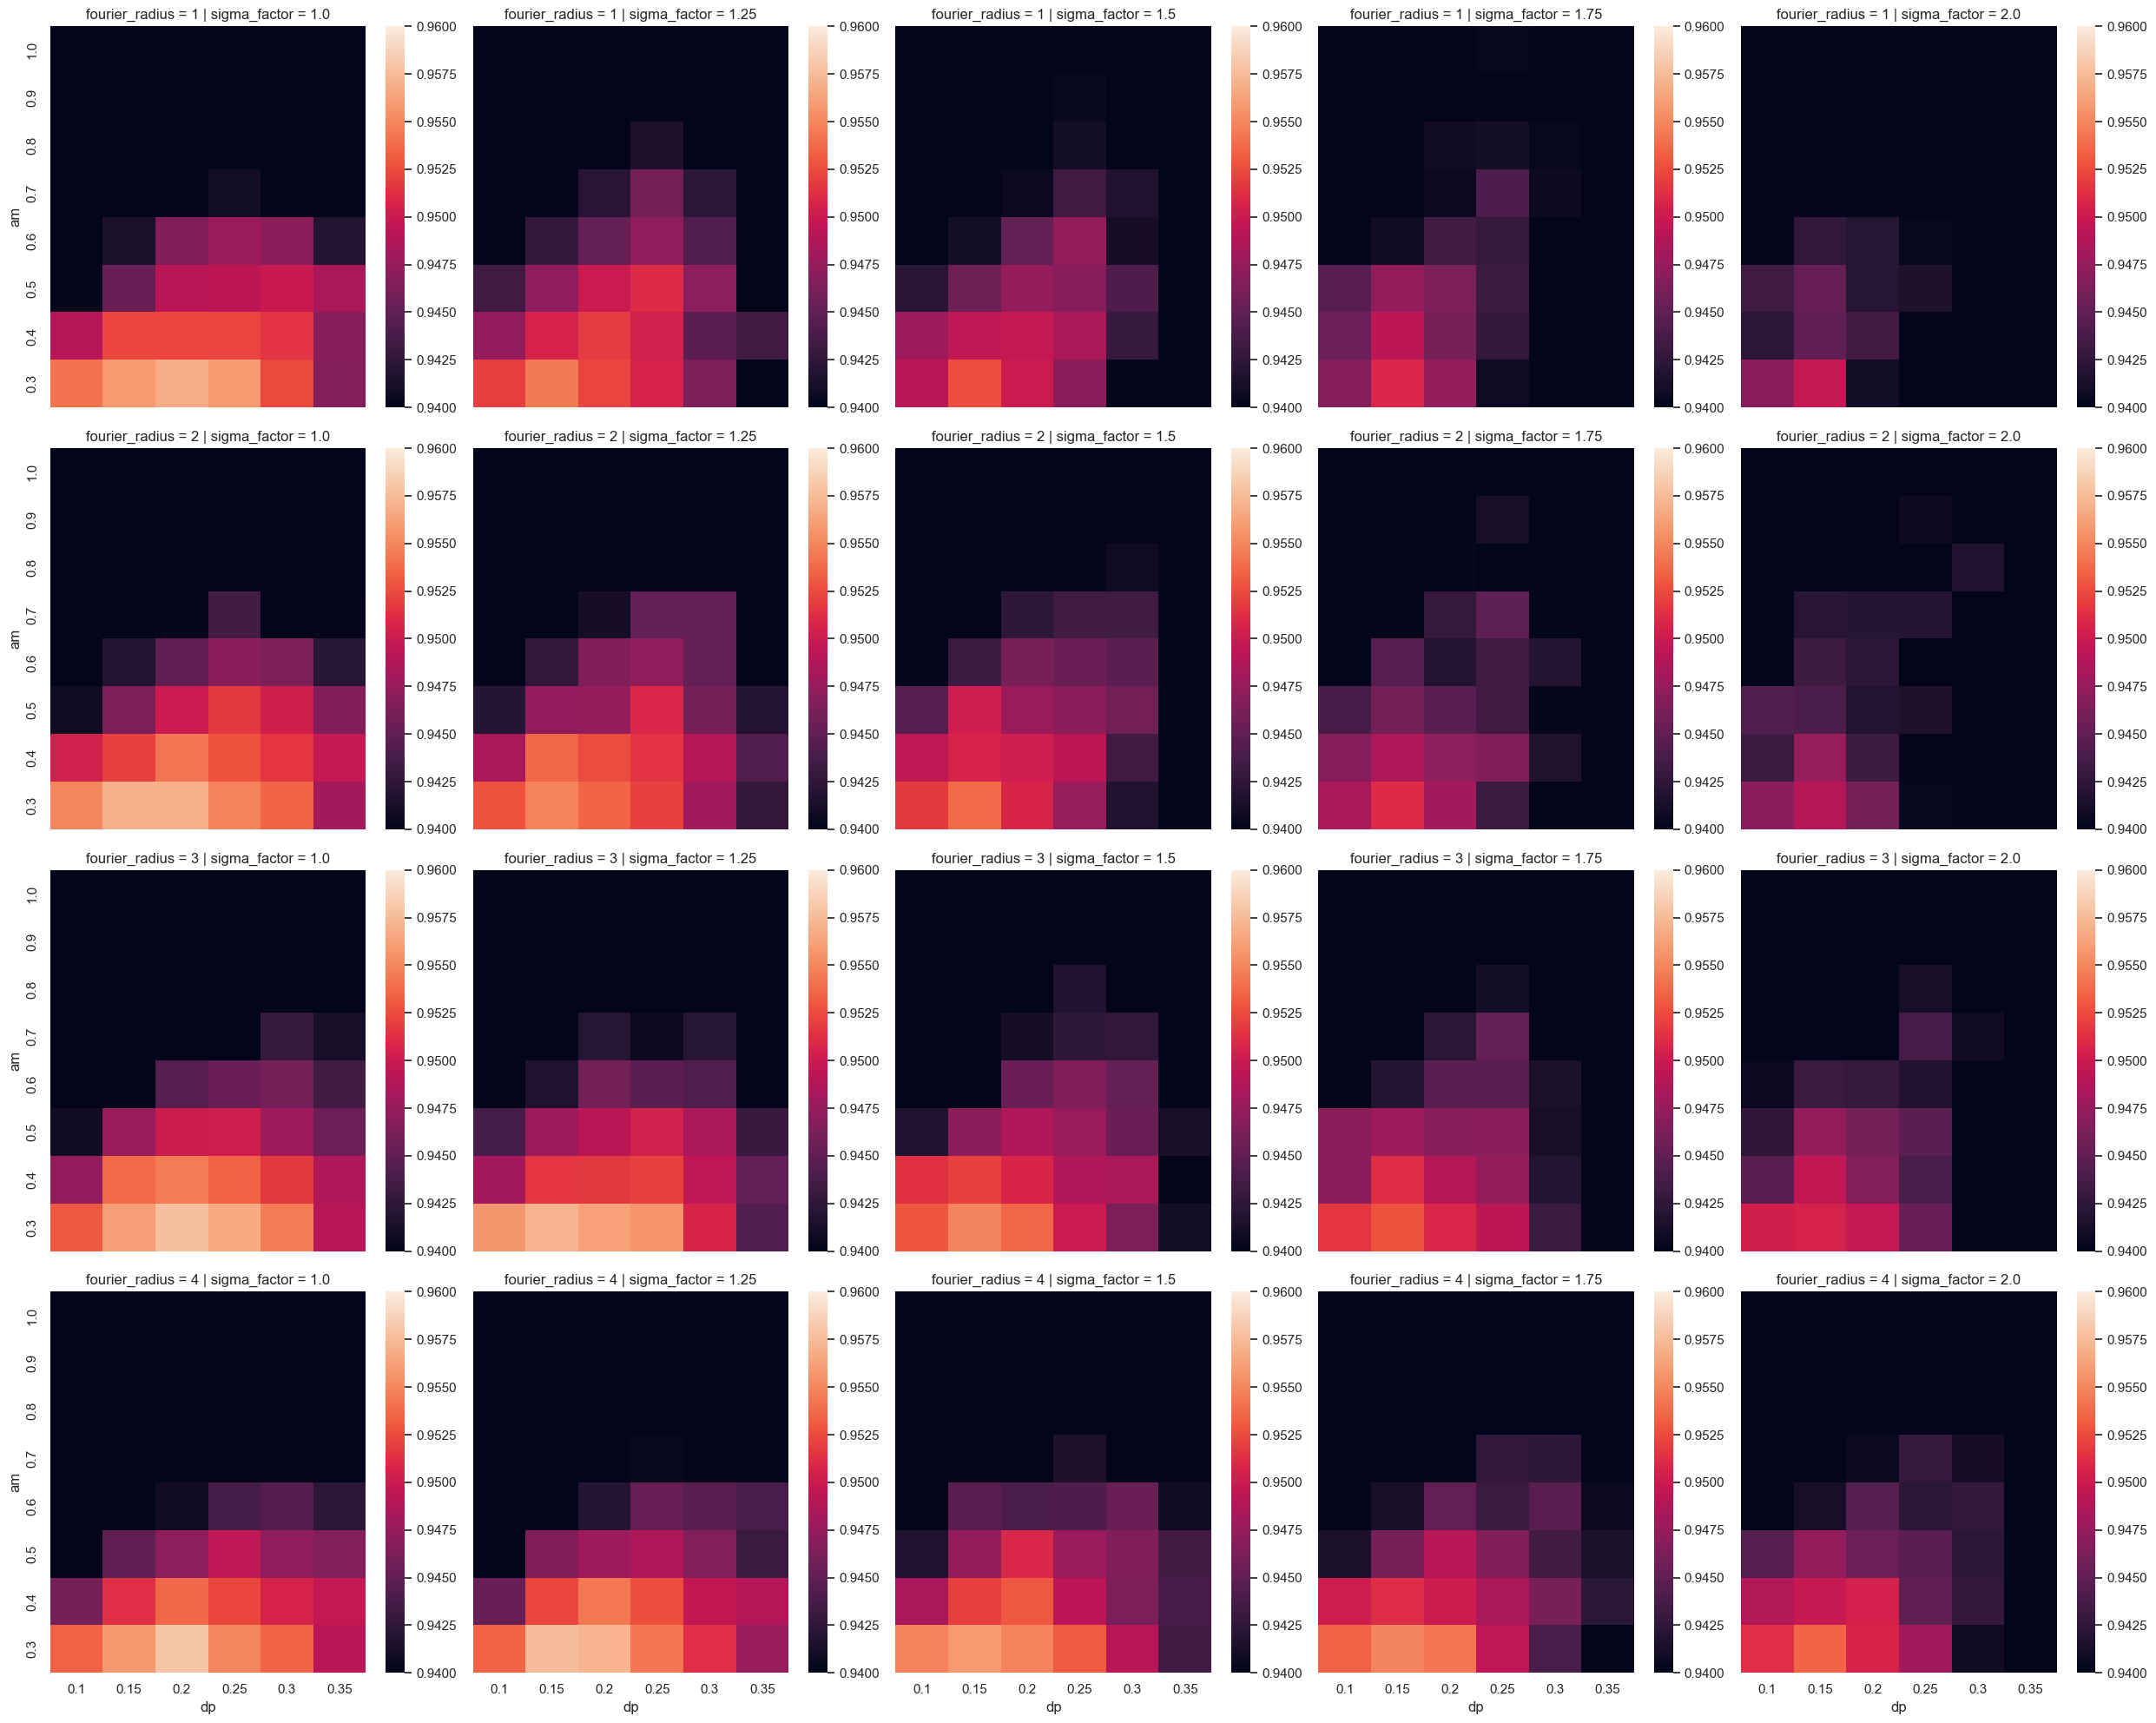

In [175]:
data = caldf.query('fourier_radius > 0 & intsteps == 3 & ballspacing == 1')
fg = sns.FacetGrid(data, col='sigma_factor', row='fourier_radius', height=5, aspect=1)
fg.map_dataframe(draw_heatmap, 'dp', 'am', 'corr_bot', vmin=vmin, vmax=vmax, cbar=True)

In [45]:
# unit in m/s for Stein simulation for 1 px / frame interval
u = 368000 / 60
trange = [0, 60]
fwhm = 7
trim = 10 # Same as Benoit
fov = np.s_[trim:-trim:fwhm, trim:-trim:fwhm]
# Get Stein velocity
datadir_stein = os.path.join(os.environ['DATA'], 'Ben/SteinSDO/')
svx_files = sorted(glob.glob(os.path.join(datadir_stein, 'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(datadir_stein, 'SDO_vy*.fits')))
vx_stein, vy_stein = load_vel_mean((svx_files, svy_files), trange)